```markdown
MACHINE LEARNING EMG PROJECT
```
``
Project Workflow
``
`
Data pre-processing
`
Feature Design
`
Develelopment of Models
`
Training
`

In [1]:
import pandas as pd
import numpy as np 
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pickle
import os
from sklearn.metrics import classification_report, accuracy_score


In [2]:
#readin in the data
df = pd.read_csv('Project_Data_EE4C12_S&S_EMG.csv')
classes=np.array([
    'unmarked data',
    'hand at rest',
    'hand clenched in a fist',
    'wrist flexion',
    'wrist extension',
    'radial deviations',
    'ulnar deviations',
    'extended palm'
])

print(df.head())
print(df.shape)
num_samples = df.shape[0]

   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


`
check for n/a values
`

In [3]:
na_counts = df.isna().sum()
display(na_counts.T)

time        0
channel1    0
channel2    0
channel3    0
channel4    0
channel5    0
channel6    0
channel7    0
channel8    0
class       0
label       0
dtype: int64

In [4]:

print("There are " + str(df['label'].nunique()) + " unique subjects in the dataset (different people performing the gestures).")
grouped_df = df.groupby(['label', 'class']).size().unstack(fill_value=0)
display(grouped_df.T)

There are 36 unique subjects in the dataset (different people performing the gestures).


label,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
class,,,,,,,,,,,,,,,,,,,,,
0,78682,94654,67770,72578,68057,61128,82641,80264,90407,81875,...,64660,64522,64093,98180,53642,75148,73298,85693,60383,65538
1,7311,7140,6443,6471,6506,5814,7523,6468,7083,7690,...,7167,5232,6317,8047,6924,6650,7082,7553,6703,6391
2,6806,6777,6301,6598,6806,6243,7651,6537,6019,6571,...,6686,5628,6460,7279,5975,8085,6316,7458,6247,6093
3,7329,6815,6486,6875,6874,6663,8383,5939,5838,6534,...,6654,5488,7495,7480,6197,8271,6127,7274,6422,6078
4,6824,6812,6421,7193,6724,6688,8923,6027,5776,6766,...,7309,5733,7059,7061,6180,8386,6527,7732,6653,5926
5,7075,6856,6278,7423,6098,7094,8414,6237,6050,6658,...,7405,5245,7261,6700,6028,8604,6225,7710,6897,5743
6,7143,7372,6086,7060,6183,5989,9105,6476,6474,6995,...,6918,5918,7302,7223,6077,7786,6530,7782,6196,5985
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6591,0,0,0,0,0,0


Percentage of samples for each class relative to the total number of samples:

Percentage of samples for class 0 relative to the total number of samples: 64.30%
Percentage of samples for class 1 relative to the total number of samples: 5.90%
Percentage of samples for class 2 relative to the total number of samples: 5.74%
Percentage of samples for class 3 relative to the total number of samples: 5.89%
Percentage of samples for class 4 relative to the total number of samples: 5.94%
Percentage of samples for class 5 relative to the total number of samples: 5.94%
Percentage of samples for class 6 relative to the total number of samples: 5.97%
Percentage of samples for class 7 relative to the total number of samples: 0.32%


Number of nonzero elements for class 7: 2, for patients (array([10, 29]),)


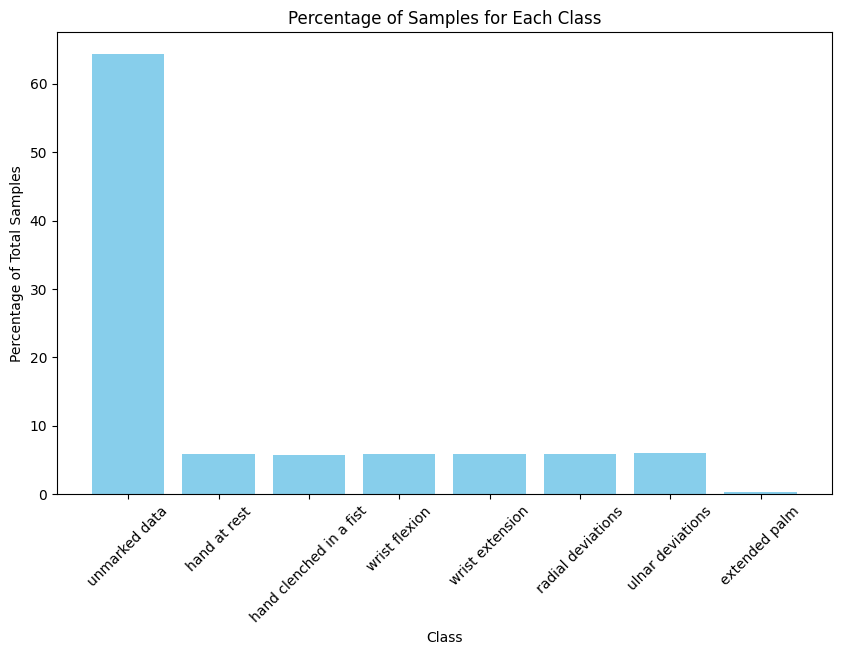

In [5]:
nonzero_count = np.count_nonzero(grouped_df.T.iloc[7])
print(f"Percentage of samples for each class relative to the total number of samples:\n")
for i in range(8):
    nonzero_count = np.count_nonzero(grouped_df.T.iloc[i])
    print(f"Percentage of samples for class {i} relative to the total number of samples: {np.sum(grouped_df.T.iloc[i])/num_samples*100:.2f}%")

print(f"\n\nNumber of nonzero elements for class {i}: {nonzero_count}, for patients {np.nonzero(grouped_df.T.iloc[7])}")

# Calculate the percentages
percentages = [np.sum(grouped_df.T.iloc[i]) / num_samples * 100 for i in range(8)]
# Plot the percentages
plt.figure(figsize=(10, 6))
plt.bar(classes[:8], percentages, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Percentage of Total Samples')
plt.title('Percentage of Samples for Each Class')
plt.xticks(rotation=45)
plt.show()


`
Due to the limited information available on class 7 it was decided that we would only classify on the first 6 classes
`

In [6]:

df_preprocessed = df[df['class'] != 7]


``
Lets us visualise the data
``

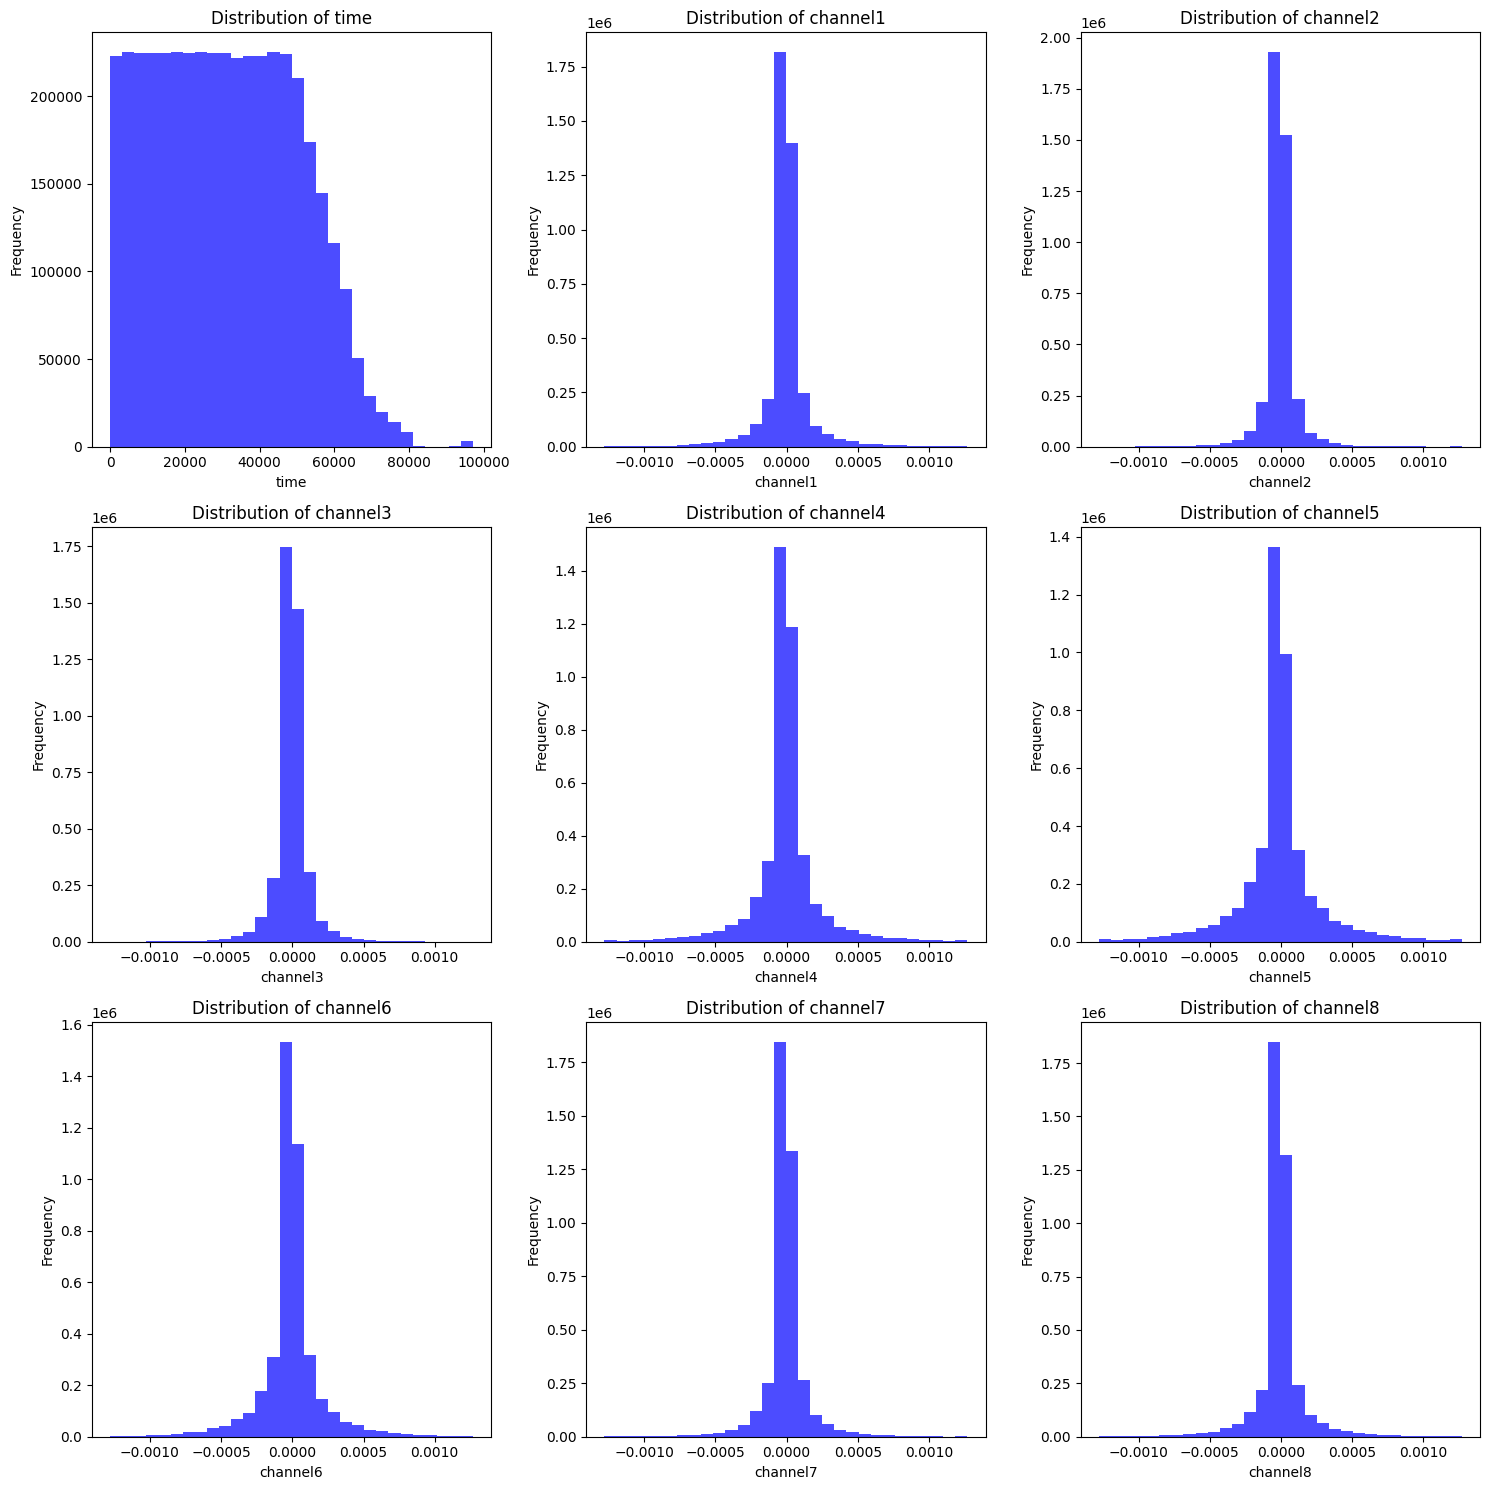

In [7]:
import matplotlib.pyplot as plt

# Select only the feature columns (assuming there are 9 features)
feature_columns = df_preprocessed.columns[0:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distribution of each feature
for i, feature in enumerate(feature_columns):
    axes[i].hist(df_preprocessed[feature], bins=30, alpha=0.7, color='b')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

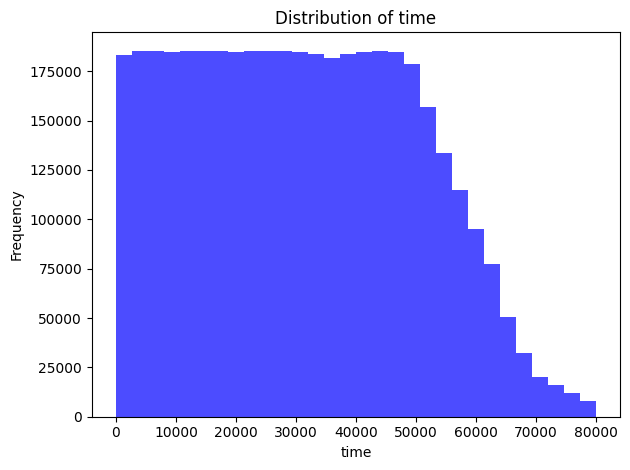

In [17]:
df_preprocessed = df_preprocessed[df_preprocessed['time']< 80000]
y = df_preprocessed['class']
# Select only the feature columns (assuming there are 9 features)
feature_columns = df_preprocessed.columns[0:9]

# Create a 3x3 grid of subplots


# Flatten the axes array for easy iteration
axes = axes.flatten()

plt.hist(df_preprocessed["time"], bins=30, alpha=0.7, color='b')
plt.title('Distribution of time')
plt.xlabel("time")
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

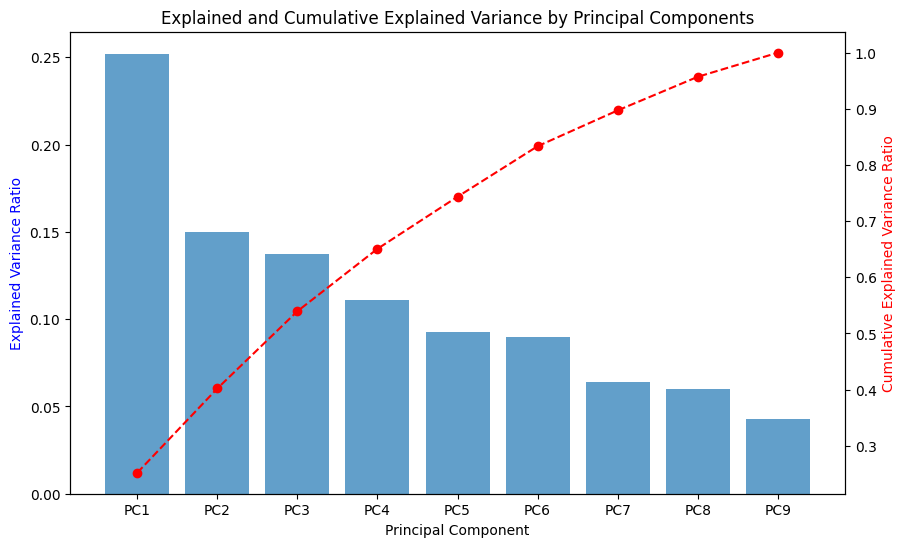

In [15]:


# Select only the feature columns (excluding 'class', and 'label')
feature_columns = df_preprocessed.columns[0:9]
X = df_preprocessed[feature_columns]

# Standardize the features
X_standardized = (X - X.mean()) / X.std()

# Apply PCA
pca = PCA()
pca.fit(X_standardized)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance and cumulative explained variance on the same figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the explained variance
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio', color='b')
ax1.set_title('Explained and Cumulative Explained Variance by Principal Components')
ax1.set_xticks(range(1, len(explained_variance) + 1))
ax1.set_xticklabels([f'PC{i}' for i in range(1, len(explained_variance) + 1)])

# Create a second y-axis for the cumulative explained variance
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='r')
ax2.set_ylabel('Cumulative Explained Variance Ratio', color='r')

plt.show()


### more than 80% of the variance is explained by the first 6 components, we will try performance of reduced and full data


In [18]:

# Take the first 100000 samples
n_components = 6 # Change this value as needed
# Apply PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)

# Split the data into train and test sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print(f"Training set shape of pca reduced data: {X_train_pca.shape}")
print(f"Test set shape of pca reduced data: {X_test_pca.shape}")
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

print(f"Training set shape : {X_train.shape}")
print(f"Test set shape: {X_test.shape}")



Training set shape of pca reduced data: (40000, 6)
Test set shape of pca reduced data: (10000, 6)
Training set shape : (40000, 9)
Test set shape: (10000, 9)



# Model selection/implementation



## SVM


In [20]:
# Define the directory and base filename
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Define the different kernels to train

kernels = ['linear', 'rbf', 'poly']



# Iterate over each kernel type
for kernel in kernels:
    # Initialize the SVM model with the specified kernel
    svm_model = SVC(kernel=kernel,tol=1e-3, max_iter=1000)
    
    # Train the model on the PCA-reduced training data
    svm_model.fit(X_train_pca, y_train)
    
    # Make predictions on the PCA-reduced test data
    y_pred = svm_model.predict(X_test_pca)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Kernel: {kernel}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    
    # Prepare the model filename with kernel name
    version = 1
    while True:
        model_filename = f"{kernel}_svm_{version}.pkl"
        model_path = os.path.join(model_dir, model_filename)
        if not os.path.exists(model_path):
            break
        version += 1

    # Save the model and training loss
    with open(model_path, 'wb') as f:
        pickle.dump({'model': svm_model}, f)

    print(f"Model with {kernel} kernel saved as {model_path}\n")


/home/frank/miniconda3/envs/ML/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Kernel: linear
Accuracy: 0.15
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.07      0.13      6320
           1       0.15      0.72      0.25       764
           2       0.26      0.04      0.06       694
           3       0.13      0.33      0.19       765
           4       0.40      0.08      0.13       699
           5       0.05      0.29      0.09       333
           6       0.02      0.08      0.04       425

    accuracy                           0.15     10000
   macro avg       0.22      0.23      0.13     10000
weighted avg       0.40      0.15      0.13     10000

Model with linear kernel saved as models/linear_svm_2.pkl



In [22]:
version = 1
kernel = 'linear'
while True:
        model_filename = f"{kernel}_svm_{version}.pkl"
        model_path = os.path.join(model_dir, model_filename)
        if  os.path.exists(model_path):
            break
        version += 1

# Load the pickled model
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)['model']

# Make predictions on the test data
y_pred_loaded = loaded_model.predict(X_test_pca)

# Evaluate the model
accuracy_loaded = accuracy_score(y_test_pca, y_pred_loaded)
report_loaded = classification_report(y_test_pca, y_pred_loaded)

print(f"Loaded Model Accuracy: {accuracy_loaded:.2f}")
print("Loaded Model Classification Report:")
print(report_loaded)

Loaded Model Accuracy: 0.63
Loaded Model Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      6320
           1       0.00      0.00      0.00       764
           2       0.00      0.00      0.00       694
           3       0.00      0.00      0.00       765
           4       0.00      0.00      0.00       699
           5       0.00      0.00      0.00       333
           6       0.00      0.00      0.00       425

    accuracy                           0.63     10000
   macro avg       0.09      0.14      0.11     10000
weighted avg       0.40      0.63      0.49     10000



/home/frank/miniconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/frank/miniconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/frank/miniconda3/envs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le